In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
from sklearn import svm
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
def preprocess():
    """ 
     Input:
     Although this function doesn't have any input, you are required to load
     the MNIST data set from file 'mnist_all.mat'.

     Output:
     train_data: matrix of training set. Each row of train_data contains 
       feature vector of a image
     train_label: vector of label corresponding to each image in the training
       set
     validation_data: matrix of training set. Each row of validation_data 
       contains feature vector of a image
     validation_label: vector of label corresponding to each image in the 
       training set
     test_data: matrix of training set. Each row of test_data contains 
       feature vector of a image
     test_label: vector of label corresponding to each image in the testing
       set
    """

    mat = loadmat('mnist_all.mat')  # loads the MAT object as a Dictionary

    n_feature = mat.get("train1").shape[1]
    n_sample = 0
    for i in range(10):
        n_sample = n_sample + mat.get("train" + str(i)).shape[0]
    n_validation = 1000
    n_train = n_sample - 10 * n_validation

    # Construct validation data
    validation_data = np.zeros((10 * n_validation, n_feature))
    for i in range(10):
        validation_data[i * n_validation:(i + 1) * n_validation, :] = mat.get("train" + str(i))[0:n_validation, :]

    # Construct validation label
    validation_label = np.ones((10 * n_validation, 1))
    for i in range(10):
        validation_label[i * n_validation:(i + 1) * n_validation, :] = i * np.ones((n_validation, 1))

    # Construct training data and label
    train_data = np.zeros((n_train, n_feature))
    train_label = np.zeros((n_train, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("train" + str(i)).shape[0]
        train_data[temp:temp + size_i - n_validation, :] = mat.get("train" + str(i))[n_validation:size_i, :]
        train_label[temp:temp + size_i - n_validation, :] = i * np.ones((size_i - n_validation, 1))
        temp = temp + size_i - n_validation

    # Construct test data and label
    n_test = 0
    for i in range(10):
        n_test = n_test + mat.get("test" + str(i)).shape[0]
    test_data = np.zeros((n_test, n_feature))
    test_label = np.zeros((n_test, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("test" + str(i)).shape[0]
        test_data[temp:temp + size_i, :] = mat.get("test" + str(i))
        test_label[temp:temp + size_i, :] = i * np.ones((size_i, 1))
        temp = temp + size_i

    # Delete features which don't provide any useful information for classifiers
    sigma = np.std(train_data, axis=0)
    index = np.array([])
    for i in range(n_feature):
        if (sigma[i] > 0.001):
            index = np.append(index, [i])
    train_data = train_data[:, index.astype(int)]
    validation_data = validation_data[:, index.astype(int)]
    test_data = test_data[:, index.astype(int)]

    # Scale data to 0 and 1
    train_data /= 255.0
    validation_data /= 255.0
    test_data /= 255.0

    return train_data, train_label, validation_data, validation_label, test_data, test_label

In [3]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [4]:
def blrObjFunction(initialWeights, *args):
    """
    blrObjFunction computes 2-class Logistic Regression error function and
    its gradient.

    Input:
        initialWeights: the weight vector (w_k) of size (D + 1) x 1 
        train_data: the data matrix of size N x D
        labeli: the label vector (y_k) of size N x 1 where each entry can be either 0 or 1 representing the label of corresponding feature vector

    Output: 
        error: the scalar value of error function of 2-class logistic regression
        error_grad: the vector of size (D+1) x 1 representing the gradient of
                    error function
    """
    train_data, labeli = args

    n_data = train_data.shape[0]
    n_features = train_data.shape[1]
    error = 0
    error_grad = np.zeros((n_features + 1, 1))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data

    X = np.concatenate((np.ones((n_data, 1)), train_data), axis = 1)
    # print(X.shape)
    # print(initialWeights.shape)
    w = np.array(initialWeights.reshape((n_features + 1, 1)))
    error = (-1.0 / n_data) * (np.sum(labeli * np.log(sigmoid(X.dot(w))) + (1.0 - labeli) * np.log(1.0 - sigmoid(X.dot(w)))))
    error_grad = (1.0 / n_data) * np.sum((sigmoid(X.dot(w)) - labeli) * X, axis = 0)

    return error, error_grad

In [5]:
def blrPredict(W, data):
    """
     blrObjFunction predicts the label of data given the data and parameter W 
     of Logistic Regression
     
     Input:
         W: the matrix of weight of size (D + 1) x 10. Each column is the weight 
         vector of a Logistic Regression classifier.
         X: the data matrix of size N x D
         
     Output: 
         label: vector of size N x 1 representing the predicted label of 
         corresponding feature vector given in data matrix

    """
    label = np.zeros((data.shape[0], 1))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data

    X = np.concatenate((np.ones((data.shape[0], 1)), data), axis = 1)
    # print(X.shape)
    # print(W.shape)
    label = np.argmax(sigmoid(X.dot(W)), axis = 1)
    label = label.reshape((data.shape[0], 1))

    return label

In [6]:
def mlrObjFunction(params, *args):
    """
    mlrObjFunction computes multi-class Logistic Regression error function and
    its gradient.

    Input:
        initialWeights_b: the weight vector of size (D + 1) x 10
        train_data: the data matrix of size N x D
        labeli: the label vector of size N x 1 where each entry can be either 0 or 1
                representing the label of corresponding feature vector

    Output:
        error: the scalar value of error function of multi-class logistic regression
        error_grad: the vector of size (D+1) x 10 representing the gradient of
                    error function
    """
    train_data, labeli = args
    n_data = train_data.shape[0]
    n_feature = train_data.shape[1]
    error = 0
    error_grad = np.zeros((n_feature + 1, n_class))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data

    X = np.concatenate((np.ones((n_data, 1)), train_data), axis = 1)
    # print(X.shape)
    # print(params.shape)
    w_b = np.array(params.reshape((n_feature+1, n_class)))
    theta = np.exp(X.dot(w_b)) / (np.sum(np.exp(X.dot(w_b)), axis = 1).reshape((train_data.shape[0], 1)))
    # print(theta.shape)
    # print(labeli.shape)
    # print((labeli * np.log(theta)).shape)
    # error = -1.0 * np.sum(labeli * np.log(theta))
    error = -1.0 * np.sum(np.sum((labeli * np.log(theta)), axis = 1), axis = 0)
    error_grad = np.transpose(X).dot(theta - labeli)
    # print(error_grad.shape)
    error_grad = error_grad.flatten()

    return error, error_grad

In [7]:
def mlrPredict(W, data):
    """
     mlrObjFunction predicts the label of data given the data and parameter W
     of Logistic Regression

     Input:
         W: the matrix of weight of size (D + 1) x 10. Each column is the weight
         vector of a Logistic Regression classifier.
         X: the data matrix of size N x D

     Output:
         label: vector of size N x 1 representing the predicted label of
         corresponding feature vector given in data matrix

    """
    label = np.zeros((data.shape[0], 1))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data

    X = np.concatenate((np.ones((data.shape[0], 1)), data), axis = 1)
    # print(X.shape)
    # print(W.shape)
    theta = np.exp(X.dot(W)) / (np.sum(np.exp(X.dot(W)), axis = 1).reshape((data.shape[0], 1)))
    label = np.argmax(theta, axis = 1)
    # print(label.shape)
    label = label.reshape((data.shape[0], 1))

    return label

In [8]:
"""
Script for Logistic Regression for Binary Classification
"""
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

# number of classes
n_class = 10

# number of training samples
n_train = train_data.shape[0]

# number of features
n_feature = train_data.shape[1]

Y = np.zeros((n_train, n_class))
for i in range(n_class):
    Y[:, i] = (train_label == i).astype(int).ravel()

# Logistic Regression with Gradient Descent
W = np.zeros((n_feature + 1, n_class))
initialWeights = np.zeros((n_feature + 1, 1))
opts = {'maxiter': 100}
for i in tqdm(range(n_class)):
    labeli = Y[:, i].reshape(n_train, 1)
    args = (train_data, labeli)
    nn_params = minimize(blrObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    W[:, i] = nn_params.x.reshape((n_feature + 1,))

100%|██████████| 10/10 [11:23<00:00, 68.33s/it]


In [9]:
print('\n------------------- Training Data Set (Logistic Regression for Binary Classification) -------------------')    

train_data_order = np.array([[train_data[j] for j in range(len(train_label)) if train_label[j] == i] for i in range(10)])
#   separate each category

for i in range(10):
    train_data_order[i] = np.array(train_data_order[i])    
    #   change the <class 'list'> to <class 'numpy.ndarray'>

for i in range(10):
    predicted_label = blrPredict(W, train_data_order[i])
    print('\n Training set of category ' + str(i) + ' Accuracy: ' + str(100 * np.mean((predicted_label == i).astype(float))) + '%')

# Find the accuracy on Training Dataset
predicted_label = blrPredict(W, train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label == train_label).astype(float))) + '%')


------------------- Training Data Set (Logistic Regression for Binary Classification) -------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until



 Training set of category 0 Accuracy: 97.84684135689619%

 Training set of category 1 Accuracy: 97.91013584117032%

 Training set of category 2 Accuracy: 91.10528438886648%

 Training set of category 3 Accuracy: 89.80705515494056%

 Training set of category 4 Accuracy: 93.90747624948368%

 Training set of category 5 Accuracy: 88.30581316444244%

 Training set of category 6 Accuracy: 96.29930866205775%

 Training set of category 7 Accuracy: 94.33998100664768%

 Training set of category 8 Accuracy: 87.54895897753042%

 Training set of category 9 Accuracy: 88.7654071529602%

 Training set Accuracy:92.716%


In [10]:
print('\n------------------- Validation Data Set (Logistic Regression for Binary Classification) -------------------')

validation_data_order = np.array([[validation_data[j] for j in range(len(validation_label)) if validation_label[j] == i] for i in range(10)])
#   separate each category

for i in range(10):
    validation_data_order[i] = np.array(validation_data_order[i])    
    #   change the <class 'list'> to <class 'numpy.ndarray'>

for i in range(10):
    predicted_label = blrPredict(W, validation_data_order[i])
    print('\n Validation set of category ' + str(i) + ' Accuracy: ' + str(100 * np.mean((predicted_label == i).astype(float))) + '%')

# Find the accuracy on Validation Dataset
predicted_label = blrPredict(W, validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label == validation_label).astype(float))) + '%')


------------------- Validation Data Set (Logistic Regression for Binary Classification) -------------------

 Validation set of category 0 Accuracy: 97.6%

 Validation set of category 1 Accuracy: 96.8%

 Validation set of category 2 Accuracy: 88.0%

 Validation set of category 3 Accuracy: 88.6%

 Validation set of category 4 Accuracy: 93.7%

 Validation set of category 5 Accuracy: 86.8%

 Validation set of category 6 Accuracy: 95.7%

 Validation set of category 7 Accuracy: 92.60000000000001%

 Validation set of category 8 Accuracy: 84.6%

 Validation set of category 9 Accuracy: 90.0%

 Validation set Accuracy:91.44%


In [11]:
print('\n------------------- Testing Data Set (Logistic Regression for Binary Classification) -------------------')

test_data_order = np.array([[test_data[j] for j in range(len(test_label)) if test_label[j] == i] for i in range(10)])
#   separate each category

for i in range(10):
    test_data_order[i] = np.array(test_data_order[i])    
    #   change the <class 'list'> to <class 'numpy.ndarray'>

for i in range(10):
    predicted_label = blrPredict(W, test_data_order[i])
    print('\n Testing set of category ' + str(i) + ' Accuracy: ' + str(100 * np.mean((predicted_label == i).astype(float))) + '%')

# Find the accuracy on Testing Dataset
predicted_label = blrPredict(W, test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label == test_label).astype(float))) + '%')


------------------- Testing Data Set (Logistic Regression for Binary Classification) -------------------

 Testing set of category 0 Accuracy: 98.06122448979592%

 Testing set of category 1 Accuracy: 98.14977973568281%

 Testing set of category 2 Accuracy: 89.05038759689923%

 Testing set of category 3 Accuracy: 91.0891089108911%

 Testing set of category 4 Accuracy: 93.38085539714868%

 Testing set of category 5 Accuracy: 85.65022421524664%

 Testing set of category 6 Accuracy: 94.88517745302714%

 Testing set of category 7 Accuracy: 92.60700389105058%

 Testing set of category 8 Accuracy: 87.06365503080082%

 Testing set of category 9 Accuracy: 89.09811694747275%

 Testing set Accuracy:92.03%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
"""
Script for Logistic Regression for Multiple Classification
"""
# FOR EXTRA CREDIT ONLY
W_b = np.zeros((n_feature + 1, n_class))
initialWeights_b = np.zeros((n_feature + 1, n_class))
opts_b = {'maxiter': 100}

args_b = (train_data, Y)
nn_params = minimize(mlrObjFunction, initialWeights_b, jac=True, args=args_b, method='CG', options=opts_b)
W_b = nn_params.x.reshape((n_feature + 1, n_class))

In [13]:
print('\n------------------- Training Data Set (Logistic Regression for Multiple Classification) -------------------')    

train_data_order_b = np.array([[train_data[j] for j in range(len(train_label)) if train_label[j] == i] for i in range(10)])
#   separate each category

for i in range(10):
    train_data_order_b[i] = np.array(train_data_order_b[i])    
    #   change the <class 'list'> to <class 'numpy.ndarray'>

for i in range(10):
    predicted_label_b = mlrPredict(W_b, train_data_order_b[i])
    print('\n Training set of category ' + str(i) + ' Accuracy: ' + str(100 * np.mean((predicted_label_b == i).astype(float))) + '%')

# Find the accuracy on Training Dataset
predicted_label_b = mlrPredict(W_b, train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label_b == train_label).astype(float))) + '%')


------------------- Training Data Set (Logistic Regression for Multiple Classification) -------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until



 Training set of category 0 Accuracy: 97.17651838309975%

 Training set of category 1 Accuracy: 97.47474747474747%

 Training set of category 2 Accuracy: 90.8229124647035%

 Training set of category 3 Accuracy: 90.6061196647827%

 Training set of category 4 Accuracy: 93.82486575795126%

 Training set of category 5 Accuracy: 89.23320515720425%

 Training set of category 6 Accuracy: 96.1569743798292%

 Training set of category 7 Accuracy: 94.22602089268756%

 Training set of category 8 Accuracy: 89.3630179344465%

 Training set of category 9 Accuracy: 91.23055162659122%

 Training set Accuracy:93.122%


In [14]:
print('\n------------------- Validation Data Set (Logistic Regression for Multiple Classification) -------------------')

validation_data_order_b = np.array([[validation_data[j] for j in range(len(validation_label)) if validation_label[j] == i] for i in range(10)])
#   separate each category

for i in range(10):
    validation_data_order_b[i] = np.array(validation_data_order_b[i])    
    #   change the <class 'list'> to <class 'numpy.ndarray'>

for i in range(10):
    predicted_label_b = mlrPredict(W_b, validation_data_order_b[i])
    print('\n Validation set of category ' + str(i) + ' Accuracy: ' + str(100 * np.mean((predicted_label_b == i).astype(float))) + '%')

# Find the accuracy on Validation Dataset
predicted_label_b = mlrPredict(W_b, validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label_b == validation_label).astype(float))) + '%')


------------------- Validation Data Set (Logistic Regression for Multiple Classification) -------------------

 Validation set of category 0 Accuracy: 97.8%

 Validation set of category 1 Accuracy: 97.6%

 Validation set of category 2 Accuracy: 90.10000000000001%

 Validation set of category 3 Accuracy: 90.10000000000001%

 Validation set of category 4 Accuracy: 94.0%

 Validation set of category 5 Accuracy: 88.9%

 Validation set of category 6 Accuracy: 95.6%

 Validation set of category 7 Accuracy: 92.5%

 Validation set of category 8 Accuracy: 86.2%

 Validation set of category 9 Accuracy: 92.60000000000001%

 Validation set Accuracy:92.54%


In [15]:
print('\n------------------- Testing Data Set (Logistic Regression for Multiple Classification) -------------------')

test_data_order_b = np.array([[test_data[j] for j in range(len(test_label)) if test_label[j] == i] for i in range(10)])
#   separate each category

for i in range(10):
    test_data_order_b[i] = np.array(test_data_order_b[i])    
    #   change the <class 'list'> to <class 'numpy.ndarray'>

for i in range(10):
    predicted_label_b = mlrPredict(W_b, test_data_order_b[i])
    print('\n Testing set of category ' + str(i) + ' Accuracy: ' + str(100 * np.mean((predicted_label_b == i).astype(float))) + '%')

# Find the accuracy on Testing Dataset
predicted_label_b = mlrPredict(W_b, test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label_b == test_label).astype(float))) + '%')


------------------- Testing Data Set (Logistic Regression for Multiple Classification) -------------------

 Testing set of category 0 Accuracy: 98.16326530612245%

 Testing set of category 1 Accuracy: 97.79735682819384%

 Testing set of category 2 Accuracy: 89.53488372093024%

 Testing set of category 3 Accuracy: 90.89108910891089%

 Testing set of category 4 Accuracy: 93.48268839103869%

 Testing set of category 5 Accuracy: 86.54708520179372%

 Testing set of category 6 Accuracy: 94.98956158663883%

 Testing set of category 7 Accuracy: 92.02334630350194%

 Testing set of category 8 Accuracy: 88.50102669404517%

 Testing set of category 9 Accuracy: 91.97224975222993%

 Testing set Accuracy:92.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
"""
Script for Support Vector Machine
"""

print('\n-------------- SVM -------------------\n')
##################
# YOUR CODE HERE #
##################

# print(train_data.shape, train_label.shape, validation_data.shape, validation_label.shape, test_data.shape, test_label.shape)

train_indices = np.random.permutation(train_data.shape[0])
random_train_data = train_data[train_indices]
random_train_label = train_label[train_indices]
# print(random_train_data.shape, random_train_label.shape)
random_train_data_10k = random_train_data[:10000]
random_train_label_10k = random_train_label[:10000]
# print(random_train_data_10k.shape, random_train_label_10k.shape)


-------------- SVM -------------------



In [17]:
print('1. linear kernel')
linear_kernel = svm.SVC(kernel = 'linear')
linear_kernel.fit(random_train_data_10k, random_train_label_10k.flatten())
print('training data accuracy: ' + str(100 * linear_kernel.score(random_train_data_10k, random_train_label_10k)) + '%')
print('validation data accuracy: ' + str(100 * linear_kernel.score(validation_data, validation_label)) + '%')
print('testing data accuracy: ' + str(100 * linear_kernel.score(test_data, test_label)) + '%')
print('------------------------------------------------------------')

print('2. radial basis function, gamma = 1.0')
rbf_1 = svm.SVC(kernel = 'rbf', gamma = 1.0)
rbf_1.fit(random_train_data_10k, random_train_label_10k.flatten())
print('training data accuracy: ' + str(100 * rbf_1.score(random_train_data_10k, random_train_label_10k)) + '%')
print('validation data accuracy: ' + str(100 * rbf_1.score(validation_data, validation_label)) + '%')
print('testing data accuracy: ' + str(100 * rbf_1.score(test_data, test_label)) + '%')
print('------------------------------------------------------------')

print('3. radial basis function, gamma = default')
rbf_default = svm.SVC(kernel = 'rbf', gamma = 'auto')

# FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. 
# Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
# "avoid this warning.", FutureWarning)

rbf_default.fit(random_train_data_10k, random_train_label_10k.flatten())
print('training data accuracy: ' + str(100 * rbf_default.score(random_train_data_10k, random_train_label_10k)) + '%')
print('validation data accuracy: ' + str(100 * rbf_default.score(validation_data, validation_label)) + '%')
print('testing data accuracy: ' + str(100 * rbf_default.score(test_data, test_label)) + '%')
print('------------------------------------------------------------')

1. linear kernel
training data accuracy: 99.63%
validation data accuracy: 92.03%
testing data accuracy: 91.5%
------------------------------------------------------------
2. radial basis function, gamma = 1.0
training data accuracy: 100.0%
validation data accuracy: 16.009999999999998%
testing data accuracy: 17.93%
------------------------------------------------------------
3. radial basis function, gamma = default
training data accuracy: 92.99%
validation data accuracy: 92.13%
testing data accuracy: 92.47999999999999%
------------------------------------------------------------


In [18]:
print('4. radial basis function, gamma = default, varying value of C')

training_data_score = np.zeros(11)
validation_data_score = np.zeros(11)
testing_data_score = np.zeros(11)
c = np.array([1.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0])

for i in tqdm(range(11)):
    rbf_default_c = svm.SVC(C = c[i], kernel = 'rbf', gamma = 'auto')
    rbf_default_c.fit(random_train_data_10k, random_train_label_10k.flatten())
    training_data_score[i] = rbf_default_c.score(random_train_data_10k, random_train_label_10k)
    validation_data_score[i] = rbf_default_c.score(validation_data, validation_label)
    testing_data_score[i] = rbf_default_c.score(test_data, test_label)

print('------------------------------------------------------------')

for i in range(11):
    print('C = ' + str(c[i]) + ', training data accuracy: ' + str(100 * training_data_score[i]) + '%')
    print('C = ' + str(c[i]) + ', validation data accuracy: ' + str(100 * validation_data_score[i]) + '%')
    print('C = ' + str(c[i]) + ', testing data accuracy: ' + str(100 * testing_data_score[i]) + '%')
    print('------------------------------------------------------------')

4. radial basis function, gamma = default, varying value of C


100%|██████████| 11/11 [13:24<00:00, 73.10s/it]

------------------------------------------------------------
C = 1.0, training data accuracy: 92.99%
C = 1.0, validation data accuracy: 92.13%
C = 1.0, testing data accuracy: 92.47999999999999%
------------------------------------------------------------
C = 10.0, training data accuracy: 96.59%
C = 10.0, validation data accuracy: 94.21000000000001%
C = 10.0, testing data accuracy: 94.22%
------------------------------------------------------------
C = 20.0, training data accuracy: 97.76%
C = 20.0, validation data accuracy: 94.59%
C = 20.0, testing data accuracy: 94.72%
------------------------------------------------------------
C = 30.0, training data accuracy: 98.41%
C = 30.0, validation data accuracy: 94.78999999999999%
C = 30.0, testing data accuracy: 94.77%
------------------------------------------------------------
C = 40.0, training data accuracy: 98.75%
C = 40.0, validation data accuracy: 94.85%
C = 40.0, testing data accuracy: 94.76%
------------------------------------------

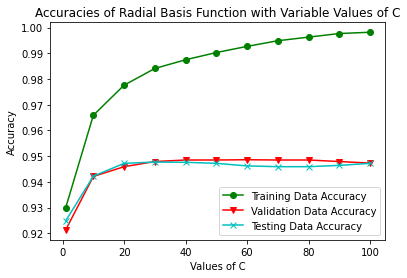

In [19]:
plt.plot(c, training_data_score, marker = 'o', color = 'g', label = 'Training Data Accuracy')
plt.plot(c, validation_data_score, marker = 'v', color = 'r', label = 'Validation Data Accuracy')
plt.plot(c, testing_data_score, marker = 'x', color = 'c', label = 'Testing Data Accuracy')

plt.title('Accuracies of Radial Basis Function with Variable Values of C')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Values of C')

plt.show()

In [20]:
print('choose the best choice of parameters, and train with the whole training dataset and report the accuracy.')
rbf_default_c_optimal = svm.SVC(C = 30.0, kernel = 'rbf', gamma = 'auto')
rbf_default_c_optimal.fit(train_data, train_label.flatten())

print('training data accuracy: ' + str(100 * rbf_default_c_optimal.score(train_data, train_label)) + '%')
print('validation data accuracy: ' + str(100 * rbf_default_c_optimal.score(validation_data, validation_label)) + '%')
print('testing data accuracy: ' + str(100 * rbf_default_c_optimal.score(test_data, test_label)) + '%')

choose the best choice of parameters, and train with the whole training dataset and report the accuracy.
training data accuracy: 98.372%
validation data accuracy: 97.1%
testing data accuracy: 97.04%
